In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

from skimage import io
from glob import glob

In [4]:
mut_crop_dir = "../data-processed/crops/mut/"

imgs = sorted(glob(mut_crop_dir+"Image*.tif"))


dtype:uint16, shape:(148, 157, 3), min:0, max:65280


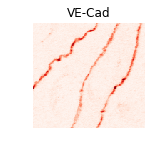

In [5]:
imarrayRG = io.imread(imgs[-1])

print("dtype:{}, shape:{}, min:{}, max:{}".format(
    imarrayRG.dtype, imarrayRG.shape, imarrayRG.min(), imarrayRG.max()))

color = 'Reds'
name = 'VE-Cad'


R = imarrayRG[:,:,0]
## Plotting under this line ##
fig, ax = plt.subplots(figsize=(2,2))


ax.imshow(R, cmap=color)
ax.set_title(name)
ax.set_axis_off()

otsu value:14080


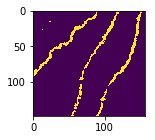

In [6]:
from skimage.filters import threshold_otsu, threshold_local

val_otsu = threshold_otsu(R)
mask = R > val_otsu

print("otsu value:{}".format(val_otsu))

val_local = threshold_local(R, block_size=3)
mask_local = R > val_local
#fig, ax = filters.try_all_threshold(R)
#fig, ax = plt.subplots(figsize=(8,8))
#ax.imshow(mask)
#plt.show()

fig, ax = plt.subplots(figsize=(2,2))
ax.imshow(mask)

li value:9177.203116137589


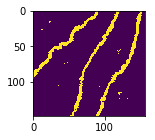

In [7]:
from skimage.filters import threshold_li

val_li = threshold_li(R)
mask = R > val_li

print("li value:{}".format(val_li))

fig, ax = plt.subplots(figsize=(2,2))
ax.imshow(mask)

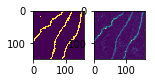

In [8]:
from skimage.morphology import binary_closing, erosion, opening

result = opening(mask)
fig, ax = plt.subplots(1,2, figsize=(2,2))
ax[0].imshow(result)
ax[1].imshow(R)

In [9]:
otsu_vals = []
li_vals = []
opened_results = []
img_arrays = []

otsu_means = []
li_means = []
opened_means = []
is_p120 = []
n = []

for img_file in imgs:
    is_p120.append("+" in img_file)
    img = io.imread(img_file)[:,:,0]
    img_arrays.append(img)
    
    temp_otsu_val = threshold_otsu(img)    
    temp_li_val = threshold_li(img)
    opened_result = opening(img > temp_li_val)
    
    otsu_mean = img[img > temp_otsu_val].mean()
    li_mean = img[img > temp_li_val].mean()
    opened_mean = img[opened_result].mean()
    
    otsu_means.append(otsu_mean)
    otsu_vals.append(temp_otsu_val)
    li_means.append(li_mean)
    li_vals.append(temp_li_val)
    opened_results.append(opened_result)
    opened_means.append(opened_mean)
    n.append(np.sum(opened_result))

is_p120 = np.asarray(is_p120)
opened_means = np.asarray(opened_means)
li_means = np.asarray(li_means)
n = np.asarray(n)

In [10]:
opened_means[~is_p120]

array([ 20388.42276423,  17132.39148936,  22932.95906433,  11066.61152142,
        10447.23809524,   9735.78115502,  14955.19388231,  17818.80470588,
        13471.30019881,  19876.03057494,  14559.91836735,  13132.13774199,
        10326.11441648,  11448.        ,  15442.26746507,  14901.33333333])

In [11]:
def weighted_std(values, weights):
    weighted_avg = np.average(values, weights=weights)
    variance = np.average((values - weighted_avg)**2, weights=weights)
    return np.sqrt(variance)

In [12]:
p120_pos_std = weighted_std(opened_means[is_p120], weights = n[is_p120])

In [13]:
p120_neg_std =weighted_std(opened_means[~is_p120], weights = n[~is_p120])

In [14]:
p120_pos_avg = np.average(opened_means[is_p120], weights = n[is_p120])
p120_neg_avg = np.average(opened_means[~is_p120], weights = n[~is_p120])

print("p120+ weighted avg intensity:{}".format(p120_pos_avg))
print("p120- weighted avg intensity:{}".format(p120_neg_avg))

p120+ weighted avg intensity:24429.574777913254
p120- weighted avg intensity:15032.488025564611


In [15]:
print("p120+ unweighted avg intensity:{}".format(np.mean(opened_means[is_p120])))
print("p120- unweighted avg intensity:{}".format(np.mean(opened_means[~is_p120])))

p120+ unweighted avg intensity:25932.8098886061
p120- unweighted avg intensity:14852.156548484088


IndexError: list index out of range

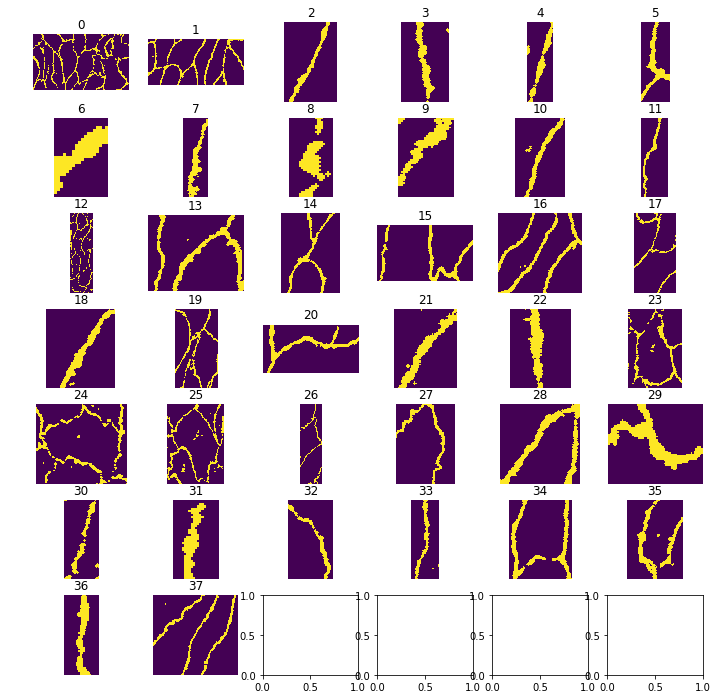

In [16]:
fig, axes = plt.subplots(7,6, figsize=(12,12))
ax = axes.ravel()

for i, a in enumerate(ax):
    #a.imshow(img_arrays[i])
    a.imshow(opened_results[i])
    a.set_title('{}'.format(i))
    a.axis('off')


IndexError: list index out of range

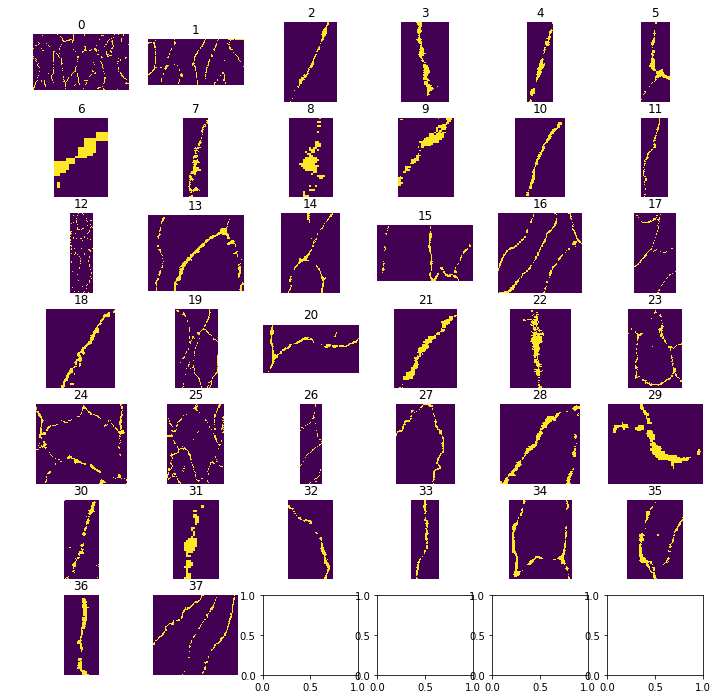

In [17]:
fig, axes = plt.subplots(7,6, figsize=(12,12))
ax = axes.ravel()

for i, a in enumerate(ax):
    #a.imshow(img_arrays[i])
    a.imshow(img_arrays[i] > li_means[i])
    a.set_title('{}'.format(i))
    a.axis('off')

In [18]:
from statsmodels.stats.weightstats import ttest_ind

ttest_ind(opened_means[is_p120], opened_means[~is_p120],
         alternative='larger',
         usevar='unequal',
         weights = [n[is_p120], n[~is_p120]],
         value=0.)

(492.10218935512972, 0.0, 63259.463810701367)

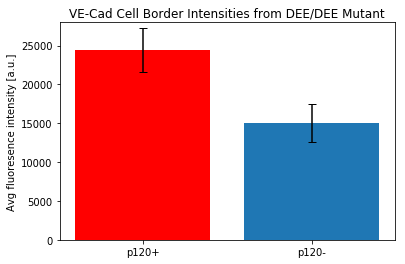

In [19]:
## These means and stds are weighted
means = (p120_pos_avg, p120_neg_avg)
stds = (p120_pos_std, p120_neg_std)
ind = np.arange(len(means))
bar_names = ("p120+", "p120-")

p_pos, p_neg = plt.bar(ind, means, yerr=stds, capsize=4)

p_pos.set_facecolor('r')
plt.ylim([0, 28000])
plt.ylabel('Avg fluoresence intensity [a.u.]')
plt.title("VE-Cad Cell Border Intensities from DEE/DEE Mutant")
plt.xticks(ind, bar_names)
plt.savefig("../plots/bar_chart_ve-cad_border_intensities_Tie2-Cre_DEE-DEE_flox-flox.png")
plt.savefig("../plots/bar_chart_ve-cad_border_intensities_Tie2-Cre_DEE-DEE_flox-flox.pdf")


In [20]:
p120_neg_avg / p120_pos_avg

0.61533973318092561

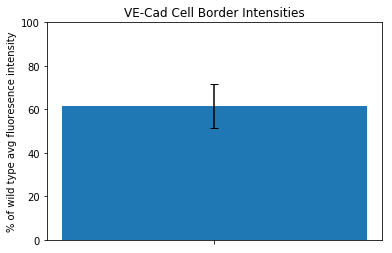

In [21]:
normed_neg_p120_avg = p120_neg_avg/p120_pos_avg * 100
normed_neg_p120_std = p120_neg_std/p120_pos_avg * 100

means = (normed_neg_p120_avg)
stds = (normed_neg_p120_std)
ind = np.arange(1)
#bar_names = ("")

p_neg = plt.bar(ind, means, yerr=stds, capsize=4)

plt.ylabel('% of wild type avg fluoresence intensity')
plt.title("VE-Cad Cell Border Intensities")
plt.xticks(ind, "")
plt.ylim([0, 100])

plt.savefig("../plots/normalized_ve-cad-intensity_Tie2-Cre_DEE-DEE_flox-flox.png")
plt.savefig("../plots/normalized_ve-cad-intensity_Tie2-Cre_DEE-DEE_flox-flox.pdf")

In [22]:
normed_neg_p120_std

10.131492275611306